# Imports

In [1]:
import tqdm
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchfm.model.dfm import DeepFactorizationMachineModel
from torchfm.model.fm import FactorizationMachineModel

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset and Preprocessing

In [3]:
ratings = pd.read_csv('Small/data/ratings.csv')
movies = pd.read_csv('Small/data/movie_features.csv')


In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = movie_encoder.fit_transform(ratings['movieId'])
ratings


,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931
...,...,...,...,...
100831,609,9416,4.0,1493848402
100832,609,9443,5.0,1493850091
100833,609,9444,5.0,1494273047
100834,609,9445,5.0,1493846352


In [6]:
n_users, n_items = ratings['userId'].nunique(), ratings['movieId'].nunique()
field_dims = np.array([n_users, n_items])
field_dims

array([ 610, 9724])

In [7]:
train_ratings, test_ratings = train_test_split(ratings.values, test_size=0.2, random_state=0)
train_ratings = pd.DataFrame(train_ratings, columns=ratings.columns)
test_ratings = pd.DataFrame(test_ratings, columns=ratings.columns)

In [8]:
train_ratings

,userId,movieId,rating,timestamp
0,482.0,5213.0,4.0,1.215545e+09
1,598.0,5879.0,2.5,1.498518e+09
2,246.0,3814.0,2.0,1.467645e+09
3,110.0,4900.0,3.5,1.516141e+09
4,609.0,6651.0,4.5,1.493848e+09
...,...,...,...,...
80663,139.0,1072.0,4.0,9.496673e+08
80664,303.0,1260.0,4.0,8.962684e+08
80665,287.0,1904.0,5.0,9.761393e+08
80666,291.0,1004.0,3.0,1.323632e+09


In [9]:
test_ratings

,userId,movieId,rating,timestamp
0,275.0,615.0,5.0,8.583504e+08
1,598.0,4970.0,2.5,1.519236e+09
2,482.0,1008.0,2.5,1.215895e+09
3,201.0,2576.0,3.0,9.749241e+08
4,273.0,6763.0,4.0,1.296947e+09
...,...,...,...,...
20163,355.0,4476.0,2.0,1.229140e+09
20164,537.0,3979.0,5.0,1.307846e+09
20165,81.0,2248.0,3.5,1.084468e+09
20166,473.0,4561.0,4.0,1.064172e+09


In [10]:
class RatingsDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        n_users, n_items = ratings['userId'].nunique(), ratings['movieId'].nunique()
        self.field_dims = np.array([n_users, n_items])
        
        self.items = ratings.values[:, :2].astype(int)
        self.targets = self.__preprocess_target(ratings.values[:, 2]).astype(bool)

        self.user_field_idx = np.array((0,), dtype=int)
        self.item_field_idx = np.array((1,), dtype=int)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target
    
train_set = RatingsDataset(train_ratings)
test_set = RatingsDataset(test_ratings)

# Training

### Factorization Machine

  0%|          | 0/50 [00:00<?, ?it/s]

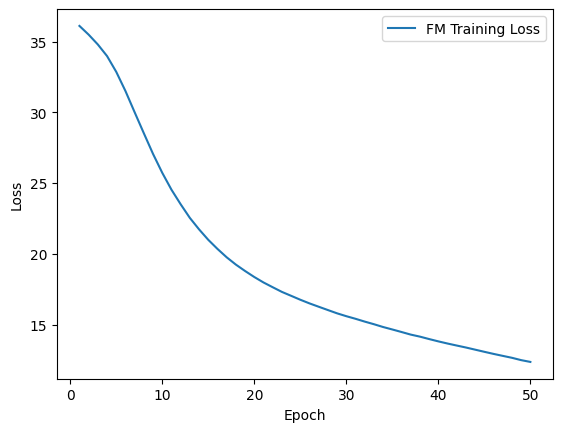

In [11]:
EPOCHS = 50
BATCH_SIZE = 2048
LR = 0.001
DECAY = 1e-6

fm = FactorizationMachineModel(field_dims, embed_dim=16).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=fm.parameters(), lr=LR, weight_decay=DECAY)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

fm.train()
loss_list_epoch = []
for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    for batch in train_loader:
        fields, target = batch[0].to(device), batch[1].to(device)
        y = fm(fields)
        loss = criterion(y, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_list_epoch.append(round(np.mean(epoch_loss), 4))


epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, loss_list_epoch, label='FM Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Deep Factorization Machine

  0%|          | 0/50 [00:00<?, ?it/s]

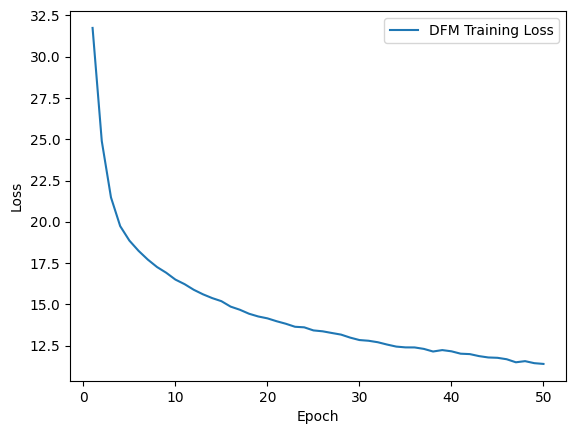

In [12]:
EPOCHS = 50
BATCH_SIZE = 2048
LR = 0.001
DECAY = 1e-6

dfm = DeepFactorizationMachineModel(field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.2).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=dfm.parameters(), lr=LR, weight_decay=DECAY)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

dfm.train()
loss_list_epoch = []
for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    for batch in train_loader:
        fields, target = batch[0].to(device), batch[1].to(device)
        y = dfm(fields)
        loss = criterion(y, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_list_epoch.append(round(np.mean(epoch_loss), 4))


epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, loss_list_epoch, label='DFM Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Recommendations

In [13]:
def recommend_movies(model, K):
    model.eval()

    recommendations = {}
    
    users = ratings['userId'].unique()
    movies = pd.Series(ratings['movieId'].unique())
    
    for user in users:
        rated_movies = ratings[ratings['userId'] == user]['movieId']
        unrated_movies = movies[~movies.isin(rated_movies)]

        user_movie_pairs = torch.from_numpy(np.array([[user, movie] for movie in unrated_movies])).to(device)
        with torch.no_grad():
            probs = model(user_movie_pairs).cpu().numpy()
    
        top_k_indices = np.argpartition(probs, -K)[-K:]
        top_k_movies = unrated_movies.iloc[top_k_indices].apply(lambda x: movie_encoder.inverse_transform([x]).item())
        recommendations[user_encoder.inverse_transform([user]).item()] = list(top_k_movies)
    
    recommendations = [(user_id, recommended_movies) for user_id, recommended_movies in recommendations.items()]
    recommendations = pd.DataFrame(recommendations, columns=['userId', 'recommended_movies'])

    return recommendations


In [14]:
fm_recommendations = recommend_movies(fm, 10)
fm_recommendations.to_csv('Small/recommendations/fm.csv')
fm_recommendations

,userId,recommended_movies
0,1,"[86345, 8254, 4326, 72737, 308, 6787, 176, 637..."
1,2,"[98124, 3768, 159061, 26900, 176, 922, 1276, 1..."
2,3,"[358, 128488, 180031, 5632, 87222, 190, 8610, ..."
3,4,"[79008, 98124, 92046, 6787, 5008, 8254, 80489,..."
4,5,"[922, 6787, 80489, 176, 98124, 86345, 92046, 8..."
...,...,...
605,606,"[7156, 80489, 3429, 2944, 40819, 4326, 72737, ..."
606,607,"[8132, 7156, 922, 80489, 8254, 86345, 4225, 98..."
607,608,"[162, 2360, 168252, 8254, 1296, 7156, 6787, 98..."
608,609,"[98124, 128620, 5712, 176, 2732, 6787, 86345, ..."


In [15]:
dfm_recommendations = recommend_movies(dfm, 10)
dfm_recommendations.to_csv('Small/recommendations/dfm.csv')
dfm_recommendations

,userId,recommended_movies
0,1,"[6612, 8147, 3429, 6752, 68932, 6886, 2917, 14..."
1,2,"[40, 3939, 122092, 37444, 35807, 147410, 14056..."
2,3,"[127298, 38095, 40959, 148881, 26326, 1260, 82..."
3,4,"[4339, 71033, 37495, 80969, 6808, 142422, 6984..."
4,5,"[26326, 94070, 2917, 1050, 64116, 60737, 1150,..."
...,...,...
605,606,"[71033, 4772, 127298, 3091, 37495, 65585, 6893..."
606,607,"[3091, 4339, 71033, 6886, 8147, 68932, 142422,..."
607,608,"[104245, 2358, 94070, 164200, 60737, 91488, 66..."
608,609,"[74668, 4339, 3201, 41863, 142422, 68932, 6558..."
